# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [47]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

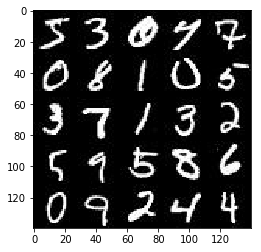

In [48]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

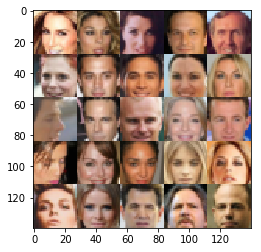

In [49]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [50]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [51]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [68]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.6):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        #bn1 = tf.layers.batch_normalization(x1, training=True)
        relu1 = tf.maximum(alpha * x1, x1)
        drop1 = tf.nn.dropout(relu1, keep_prob)
        # 14x14x64
        
        x2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob)
        # 7x7x128
        
        x3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob)
        # 4x4x256
        
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [69]:
def generator(z, out_channel_dim, is_train=True, keep_prob=0.5):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        x1 = tf.layers.dense(z, 3*3*512)
        x1 = tf.reshape(x1, (-1, 3, 3, 512))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.nn.relu(bn1)
        drop1 = tf.nn.dropout(relu1, keep_prob)
        # 3x3x512
        
        x2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.nn.relu(bn2)
        drop2 = tf.nn.dropout(relu2, keep_prob)
        # 6x6x256
        
        x3 = tf.layers.conv2d_transpose(drop2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.nn.relu(bn3)
        drop3 = tf.nn.dropout(relu3, keep_prob)
        # 12x12x128
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 6, strides=2, padding='valid')
        # 28x28xout_channel_dim
        out = tf.tanh(logits) * 0.5
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [54]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_real, labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * 0.9))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [55]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [56]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [65]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #saver = tf.train.Saver()
    print_every = 20
    show_every = 100
    n_images = 25
    steps = 0
    class GAN:
        def __init__(self, data_shape, z_dim, learning_rate, beta1):
            tf.reset_default_graph()
            
            self.input_real, self.input_z, self.learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

            self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, data_shape[3])
            self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
    net = GAN(data_shape, z_dim, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(net.d_opt, feed_dict={net.input_real: batch_images, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: batch_images})
                
                if steps % print_every == 0:
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: batch_images})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})
                    
                    print('Epoch {} Step {}...'.format(epoch_i+1, steps), 
                          'Discriminator Loss: {:.4f}...'.format(train_loss_d),
                          'Generator Loss: {:.4f}'.format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, n_images, net.input_z, data_shape[3], data_image_mode)
        #saver.save(sess, './checkpoints/generator.ckpt')
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1 Step 20... Discriminator Loss: 1.1273... Generator Loss: 0.9540
Epoch 1 Step 40... Discriminator Loss: 1.3329... Generator Loss: 1.5167
Epoch 1 Step 60... Discriminator Loss: 1.2380... Generator Loss: 1.6304
Epoch 1 Step 80... Discriminator Loss: 0.6989... Generator Loss: 2.6267
Epoch 1 Step 100... Discriminator Loss: 0.8755... Generator Loss: 2.8625


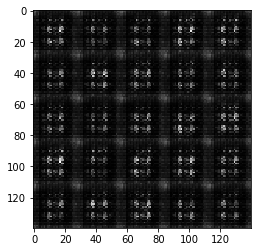

Epoch 1 Step 120... Discriminator Loss: 1.0113... Generator Loss: 1.6891
Epoch 1 Step 140... Discriminator Loss: 1.0133... Generator Loss: 1.9473
Epoch 1 Step 160... Discriminator Loss: 0.7566... Generator Loss: 2.2001
Epoch 1 Step 180... Discriminator Loss: 0.8076... Generator Loss: 2.8036
Epoch 1 Step 200... Discriminator Loss: 0.6474... Generator Loss: 2.7450


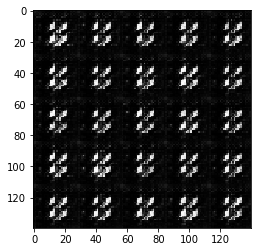

Epoch 1 Step 220... Discriminator Loss: 0.9036... Generator Loss: 3.1519
Epoch 1 Step 240... Discriminator Loss: 0.6029... Generator Loss: 2.9630
Epoch 1 Step 260... Discriminator Loss: 0.4648... Generator Loss: 3.5699
Epoch 1 Step 280... Discriminator Loss: 0.6815... Generator Loss: 2.5245
Epoch 1 Step 300... Discriminator Loss: 1.1622... Generator Loss: 1.0446


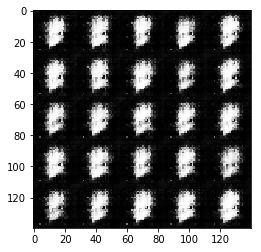

Epoch 1 Step 320... Discriminator Loss: 0.6609... Generator Loss: 2.3129
Epoch 1 Step 340... Discriminator Loss: 0.5409... Generator Loss: 3.5370
Epoch 1 Step 360... Discriminator Loss: 0.7273... Generator Loss: 2.0101
Epoch 1 Step 380... Discriminator Loss: 0.6514... Generator Loss: 2.5904
Epoch 1 Step 400... Discriminator Loss: 0.5497... Generator Loss: 2.7485


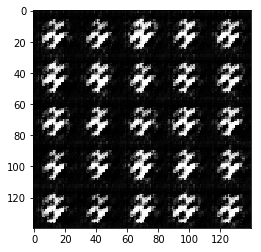

Epoch 1 Step 420... Discriminator Loss: 0.7074... Generator Loss: 1.8556
Epoch 1 Step 440... Discriminator Loss: 0.9153... Generator Loss: 2.5704
Epoch 1 Step 460... Discriminator Loss: 0.6504... Generator Loss: 2.5142
Epoch 1 Step 480... Discriminator Loss: 0.6133... Generator Loss: 2.4008
Epoch 1 Step 500... Discriminator Loss: 0.6005... Generator Loss: 3.2207


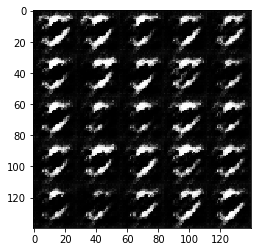

Epoch 1 Step 520... Discriminator Loss: 0.6497... Generator Loss: 3.2207
Epoch 1 Step 540... Discriminator Loss: 0.6435... Generator Loss: 3.0872
Epoch 1 Step 560... Discriminator Loss: 0.7664... Generator Loss: 2.1339
Epoch 1 Step 580... Discriminator Loss: 0.7180... Generator Loss: 1.9718
Epoch 1 Step 600... Discriminator Loss: 0.6699... Generator Loss: 2.2757


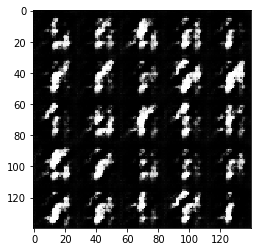

Epoch 1 Step 620... Discriminator Loss: 0.7102... Generator Loss: 2.0459
Epoch 1 Step 640... Discriminator Loss: 0.6276... Generator Loss: 2.6793
Epoch 1 Step 660... Discriminator Loss: 0.8003... Generator Loss: 2.1120
Epoch 1 Step 680... Discriminator Loss: 0.6443... Generator Loss: 2.5436
Epoch 1 Step 700... Discriminator Loss: 0.5994... Generator Loss: 2.4798


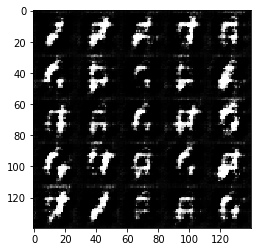

Epoch 1 Step 720... Discriminator Loss: 0.5534... Generator Loss: 2.7815
Epoch 1 Step 740... Discriminator Loss: 0.7262... Generator Loss: 3.1339
Epoch 1 Step 760... Discriminator Loss: 0.5707... Generator Loss: 2.2752
Epoch 1 Step 780... Discriminator Loss: 0.8458... Generator Loss: 1.7535
Epoch 1 Step 800... Discriminator Loss: 0.7647... Generator Loss: 2.3109


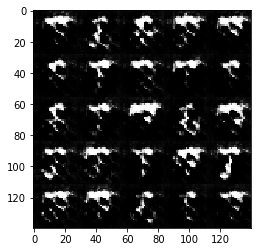

Epoch 1 Step 820... Discriminator Loss: 0.5647... Generator Loss: 2.8027
Epoch 1 Step 840... Discriminator Loss: 0.8534... Generator Loss: 1.3420
Epoch 1 Step 860... Discriminator Loss: 0.8518... Generator Loss: 1.4290
Epoch 1 Step 880... Discriminator Loss: 0.8850... Generator Loss: 1.8979
Epoch 1 Step 900... Discriminator Loss: 0.7159... Generator Loss: 2.4345


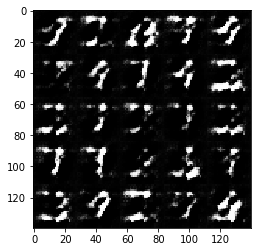

Epoch 1 Step 920... Discriminator Loss: 0.6664... Generator Loss: 2.4741
Epoch 1 Step 940... Discriminator Loss: 0.5553... Generator Loss: 2.4816
Epoch 1 Step 960... Discriminator Loss: 0.7744... Generator Loss: 1.7361
Epoch 1 Step 980... Discriminator Loss: 0.5895... Generator Loss: 2.6450
Epoch 1 Step 1000... Discriminator Loss: 0.8311... Generator Loss: 1.7063


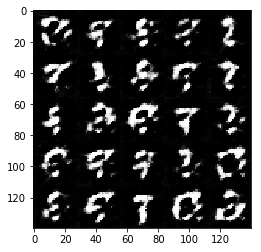

Epoch 1 Step 1020... Discriminator Loss: 0.8243... Generator Loss: 2.1194
Epoch 1 Step 1040... Discriminator Loss: 0.7443... Generator Loss: 2.5623
Epoch 1 Step 1060... Discriminator Loss: 0.7318... Generator Loss: 1.6201
Epoch 1 Step 1080... Discriminator Loss: 0.7041... Generator Loss: 2.2933
Epoch 1 Step 1100... Discriminator Loss: 0.8868... Generator Loss: 1.6021


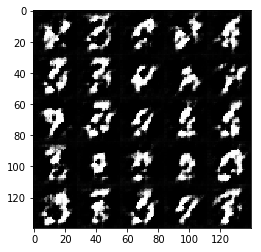

Epoch 1 Step 1120... Discriminator Loss: 0.8874... Generator Loss: 1.4794
Epoch 1 Step 1140... Discriminator Loss: 0.8848... Generator Loss: 1.2536
Epoch 1 Step 1160... Discriminator Loss: 1.0858... Generator Loss: 1.7936
Epoch 1 Step 1180... Discriminator Loss: 0.9381... Generator Loss: 1.4812
Epoch 1 Step 1200... Discriminator Loss: 0.7140... Generator Loss: 2.4236


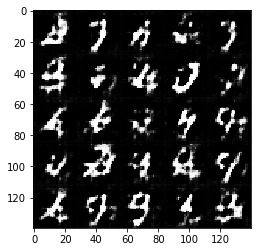

Epoch 1 Step 1220... Discriminator Loss: 0.9043... Generator Loss: 1.9181
Epoch 1 Step 1240... Discriminator Loss: 1.0519... Generator Loss: 1.1433
Epoch 1 Step 1260... Discriminator Loss: 0.9288... Generator Loss: 1.8042
Epoch 1 Step 1280... Discriminator Loss: 0.9544... Generator Loss: 2.6057
Epoch 1 Step 1300... Discriminator Loss: 0.8859... Generator Loss: 1.8182


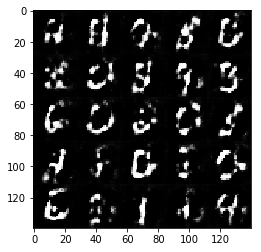

Epoch 1 Step 1320... Discriminator Loss: 0.9419... Generator Loss: 1.7983
Epoch 1 Step 1340... Discriminator Loss: 0.8328... Generator Loss: 2.2604
Epoch 1 Step 1360... Discriminator Loss: 1.1550... Generator Loss: 1.6764
Epoch 1 Step 1380... Discriminator Loss: 0.8407... Generator Loss: 1.5495
Epoch 1 Step 1400... Discriminator Loss: 1.0457... Generator Loss: 1.3405


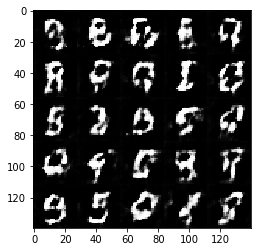

Epoch 1 Step 1420... Discriminator Loss: 0.9975... Generator Loss: 1.0409
Epoch 1 Step 1440... Discriminator Loss: 0.8784... Generator Loss: 2.2175
Epoch 1 Step 1460... Discriminator Loss: 0.7713... Generator Loss: 1.7468
Epoch 1 Step 1480... Discriminator Loss: 1.0778... Generator Loss: 1.8162
Epoch 1 Step 1500... Discriminator Loss: 0.9673... Generator Loss: 1.7146


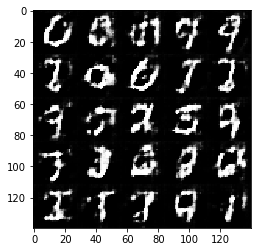

Epoch 1 Step 1520... Discriminator Loss: 1.0959... Generator Loss: 1.1998
Epoch 1 Step 1540... Discriminator Loss: 0.6859... Generator Loss: 2.0579
Epoch 1 Step 1560... Discriminator Loss: 1.0161... Generator Loss: 1.5372
Epoch 1 Step 1580... Discriminator Loss: 0.9746... Generator Loss: 2.2969
Epoch 1 Step 1600... Discriminator Loss: 0.8803... Generator Loss: 1.6397


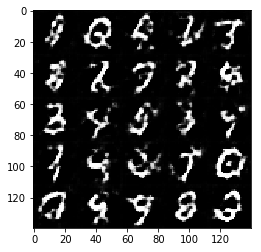

Epoch 1 Step 1620... Discriminator Loss: 1.0896... Generator Loss: 1.0725
Epoch 1 Step 1640... Discriminator Loss: 0.9171... Generator Loss: 1.0723
Epoch 1 Step 1660... Discriminator Loss: 0.7085... Generator Loss: 1.8439
Epoch 1 Step 1680... Discriminator Loss: 0.8865... Generator Loss: 1.6536
Epoch 1 Step 1700... Discriminator Loss: 0.9254... Generator Loss: 1.1518


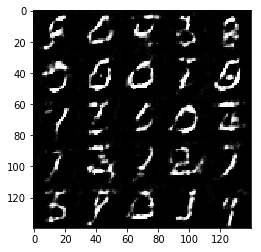

Epoch 1 Step 1720... Discriminator Loss: 1.4462... Generator Loss: 0.8102
Epoch 1 Step 1740... Discriminator Loss: 1.1665... Generator Loss: 1.2981
Epoch 1 Step 1760... Discriminator Loss: 0.9306... Generator Loss: 1.7714
Epoch 1 Step 1780... Discriminator Loss: 0.8546... Generator Loss: 2.1989
Epoch 1 Step 1800... Discriminator Loss: 1.1170... Generator Loss: 1.2849


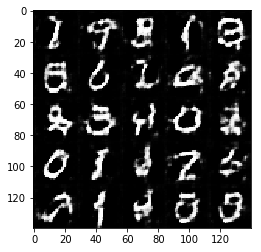

Epoch 1 Step 1820... Discriminator Loss: 1.3713... Generator Loss: 1.1364
Epoch 1 Step 1840... Discriminator Loss: 0.9585... Generator Loss: 1.6372
Epoch 1 Step 1860... Discriminator Loss: 1.3992... Generator Loss: 0.9411
Epoch 2 Step 1880... Discriminator Loss: 0.8643... Generator Loss: 1.4816
Epoch 2 Step 1900... Discriminator Loss: 0.9915... Generator Loss: 1.6367


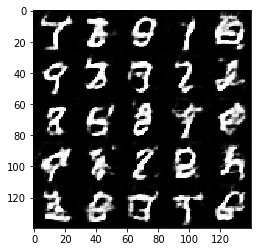

Epoch 2 Step 1920... Discriminator Loss: 1.1079... Generator Loss: 1.3359
Epoch 2 Step 1940... Discriminator Loss: 0.9509... Generator Loss: 1.3785
Epoch 2 Step 1960... Discriminator Loss: 0.9606... Generator Loss: 1.3971
Epoch 2 Step 1980... Discriminator Loss: 1.1191... Generator Loss: 1.8345
Epoch 2 Step 2000... Discriminator Loss: 1.2753... Generator Loss: 1.0356


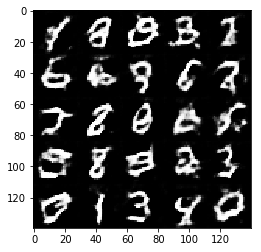

Epoch 2 Step 2020... Discriminator Loss: 0.9173... Generator Loss: 1.7376
Epoch 2 Step 2040... Discriminator Loss: 0.8541... Generator Loss: 1.3968
Epoch 2 Step 2060... Discriminator Loss: 1.1118... Generator Loss: 0.8135
Epoch 2 Step 2080... Discriminator Loss: 1.0656... Generator Loss: 1.1668
Epoch 2 Step 2100... Discriminator Loss: 0.8425... Generator Loss: 1.3682


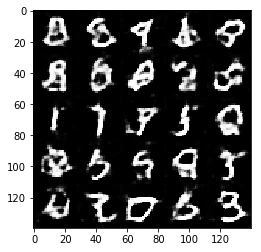

Epoch 2 Step 2120... Discriminator Loss: 1.0720... Generator Loss: 1.5988
Epoch 2 Step 2140... Discriminator Loss: 0.8988... Generator Loss: 1.4559
Epoch 2 Step 2160... Discriminator Loss: 0.8668... Generator Loss: 1.3417
Epoch 2 Step 2180... Discriminator Loss: 0.8705... Generator Loss: 1.3056
Epoch 2 Step 2200... Discriminator Loss: 1.1208... Generator Loss: 1.2998


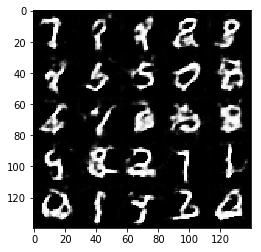

Epoch 2 Step 2220... Discriminator Loss: 0.8235... Generator Loss: 1.3394
Epoch 2 Step 2240... Discriminator Loss: 1.1693... Generator Loss: 1.2393
Epoch 2 Step 2260... Discriminator Loss: 1.1415... Generator Loss: 1.7885
Epoch 2 Step 2280... Discriminator Loss: 1.1244... Generator Loss: 1.4259
Epoch 2 Step 2300... Discriminator Loss: 0.9281... Generator Loss: 1.5668


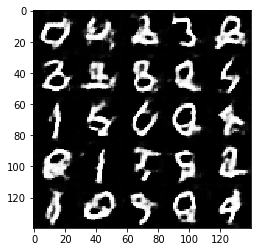

Epoch 2 Step 2320... Discriminator Loss: 0.9103... Generator Loss: 1.6160
Epoch 2 Step 2340... Discriminator Loss: 1.2745... Generator Loss: 1.5083
Epoch 2 Step 2360... Discriminator Loss: 0.9548... Generator Loss: 1.4274
Epoch 2 Step 2380... Discriminator Loss: 1.2670... Generator Loss: 0.7745
Epoch 2 Step 2400... Discriminator Loss: 1.0099... Generator Loss: 1.0950


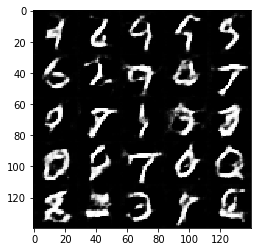

Epoch 2 Step 2420... Discriminator Loss: 1.1127... Generator Loss: 1.3548
Epoch 2 Step 2440... Discriminator Loss: 1.1016... Generator Loss: 1.0943
Epoch 2 Step 2460... Discriminator Loss: 0.9543... Generator Loss: 1.4544
Epoch 2 Step 2480... Discriminator Loss: 0.9951... Generator Loss: 1.1740
Epoch 2 Step 2500... Discriminator Loss: 0.9670... Generator Loss: 1.2979


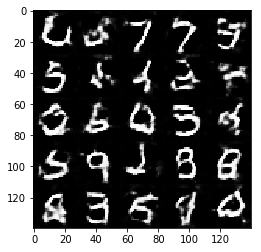

Epoch 2 Step 2520... Discriminator Loss: 0.9700... Generator Loss: 1.3608
Epoch 2 Step 2540... Discriminator Loss: 1.1357... Generator Loss: 1.6997
Epoch 2 Step 2560... Discriminator Loss: 0.8526... Generator Loss: 1.2695
Epoch 2 Step 2580... Discriminator Loss: 0.9839... Generator Loss: 1.4243
Epoch 2 Step 2600... Discriminator Loss: 1.1253... Generator Loss: 1.3728


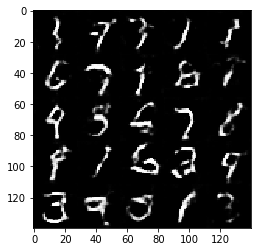

Epoch 2 Step 2620... Discriminator Loss: 0.8961... Generator Loss: 1.1093
Epoch 2 Step 2640... Discriminator Loss: 1.2625... Generator Loss: 1.0877
Epoch 2 Step 2660... Discriminator Loss: 1.0765... Generator Loss: 1.3530
Epoch 2 Step 2680... Discriminator Loss: 1.2033... Generator Loss: 1.1339
Epoch 2 Step 2700... Discriminator Loss: 1.3750... Generator Loss: 0.7136


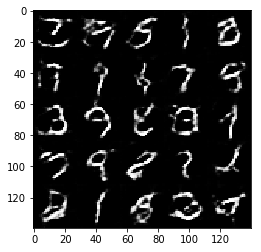

Epoch 2 Step 2720... Discriminator Loss: 1.0923... Generator Loss: 1.2986
Epoch 2 Step 2740... Discriminator Loss: 1.1166... Generator Loss: 1.3295
Epoch 2 Step 2760... Discriminator Loss: 0.9080... Generator Loss: 1.2538
Epoch 2 Step 2780... Discriminator Loss: 0.9051... Generator Loss: 1.6141
Epoch 2 Step 2800... Discriminator Loss: 1.1954... Generator Loss: 0.8747


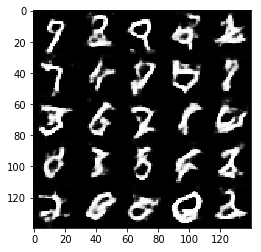

Epoch 2 Step 2820... Discriminator Loss: 0.9812... Generator Loss: 1.0842
Epoch 2 Step 2840... Discriminator Loss: 1.1831... Generator Loss: 1.1349
Epoch 2 Step 2860... Discriminator Loss: 1.2758... Generator Loss: 0.8519
Epoch 2 Step 2880... Discriminator Loss: 0.8832... Generator Loss: 1.5832
Epoch 2 Step 2900... Discriminator Loss: 1.2058... Generator Loss: 1.3370


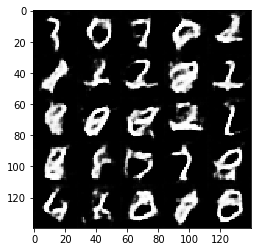

Epoch 2 Step 2920... Discriminator Loss: 1.0126... Generator Loss: 1.3344
Epoch 2 Step 2940... Discriminator Loss: 1.0764... Generator Loss: 0.9800
Epoch 2 Step 2960... Discriminator Loss: 1.0674... Generator Loss: 1.0140
Epoch 2 Step 2980... Discriminator Loss: 0.8524... Generator Loss: 1.1061
Epoch 2 Step 3000... Discriminator Loss: 0.9952... Generator Loss: 1.2578


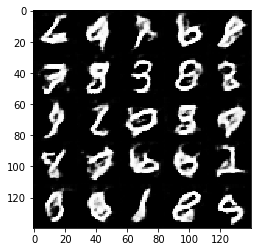

Epoch 2 Step 3020... Discriminator Loss: 1.4105... Generator Loss: 0.8532
Epoch 2 Step 3040... Discriminator Loss: 1.0013... Generator Loss: 1.7296
Epoch 2 Step 3060... Discriminator Loss: 0.8310... Generator Loss: 1.4046
Epoch 2 Step 3080... Discriminator Loss: 0.8528... Generator Loss: 1.3016
Epoch 2 Step 3100... Discriminator Loss: 1.1079... Generator Loss: 1.4268


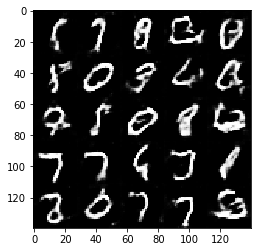

Epoch 2 Step 3120... Discriminator Loss: 0.8917... Generator Loss: 1.2039
Epoch 2 Step 3140... Discriminator Loss: 1.2969... Generator Loss: 1.1895
Epoch 2 Step 3160... Discriminator Loss: 1.2462... Generator Loss: 1.4195
Epoch 2 Step 3180... Discriminator Loss: 0.9698... Generator Loss: 0.9682
Epoch 2 Step 3200... Discriminator Loss: 0.9092... Generator Loss: 1.3966


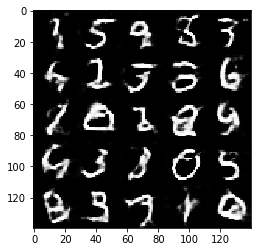

Epoch 2 Step 3220... Discriminator Loss: 0.9729... Generator Loss: 1.4460
Epoch 2 Step 3240... Discriminator Loss: 1.0782... Generator Loss: 1.8366
Epoch 2 Step 3260... Discriminator Loss: 1.3439... Generator Loss: 1.0523
Epoch 2 Step 3280... Discriminator Loss: 0.8801... Generator Loss: 1.3146
Epoch 2 Step 3300... Discriminator Loss: 1.0182... Generator Loss: 1.2174


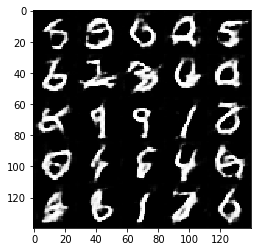

Epoch 2 Step 3320... Discriminator Loss: 0.8609... Generator Loss: 1.3414
Epoch 2 Step 3340... Discriminator Loss: 0.9114... Generator Loss: 1.4321
Epoch 2 Step 3360... Discriminator Loss: 1.0308... Generator Loss: 2.1861
Epoch 2 Step 3380... Discriminator Loss: 1.1105... Generator Loss: 1.7256
Epoch 2 Step 3400... Discriminator Loss: 1.0479... Generator Loss: 1.3254


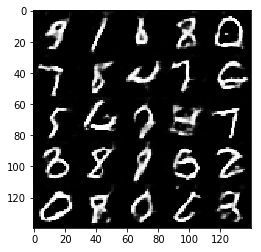

Epoch 2 Step 3420... Discriminator Loss: 1.0397... Generator Loss: 1.3770
Epoch 2 Step 3440... Discriminator Loss: 0.9566... Generator Loss: 1.2399
Epoch 2 Step 3460... Discriminator Loss: 1.1157... Generator Loss: 1.0811
Epoch 2 Step 3480... Discriminator Loss: 1.2325... Generator Loss: 1.7903
Epoch 2 Step 3500... Discriminator Loss: 0.8897... Generator Loss: 1.0285


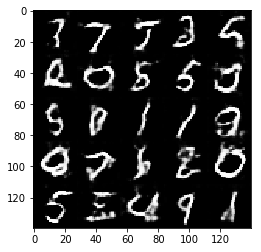

Epoch 2 Step 3520... Discriminator Loss: 1.1978... Generator Loss: 1.6253
Epoch 2 Step 3540... Discriminator Loss: 1.1029... Generator Loss: 1.5459
Epoch 2 Step 3560... Discriminator Loss: 0.9530... Generator Loss: 1.2093
Epoch 2 Step 3580... Discriminator Loss: 0.8166... Generator Loss: 1.6133
Epoch 2 Step 3600... Discriminator Loss: 1.0739... Generator Loss: 1.3727


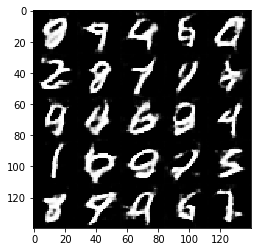

Epoch 2 Step 3620... Discriminator Loss: 0.9209... Generator Loss: 1.1270
Epoch 2 Step 3640... Discriminator Loss: 1.0998... Generator Loss: 1.3182
Epoch 2 Step 3660... Discriminator Loss: 1.0048... Generator Loss: 1.4154
Epoch 2 Step 3680... Discriminator Loss: 1.0075... Generator Loss: 1.3620
Epoch 2 Step 3700... Discriminator Loss: 0.9531... Generator Loss: 1.3562


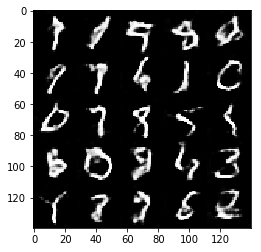

Epoch 2 Step 3720... Discriminator Loss: 1.1592... Generator Loss: 1.9299
Epoch 2 Step 3740... Discriminator Loss: 0.9368... Generator Loss: 1.0688


IndexError: list index out of range

In [74]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1 Step 20... Discriminator Loss: 0.9417... Generator Loss: 4.0924
Epoch 1 Step 40... Discriminator Loss: 0.6834... Generator Loss: 2.1679
Epoch 1 Step 60... Discriminator Loss: 1.6087... Generator Loss: 8.1188
Epoch 1 Step 80... Discriminator Loss: 1.0734... Generator Loss: 1.9247
Epoch 1 Step 100... Discriminator Loss: 1.0363... Generator Loss: 1.2216


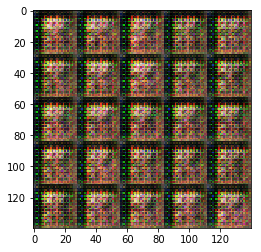

Epoch 1 Step 120... Discriminator Loss: 1.1838... Generator Loss: 1.3395
Epoch 1 Step 140... Discriminator Loss: 0.9647... Generator Loss: 1.3789
Epoch 1 Step 160... Discriminator Loss: 0.6711... Generator Loss: 2.1153
Epoch 1 Step 180... Discriminator Loss: 0.5950... Generator Loss: 3.0539
Epoch 1 Step 200... Discriminator Loss: 0.5958... Generator Loss: 2.5600


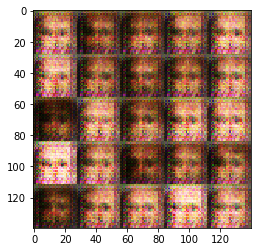

Epoch 1 Step 220... Discriminator Loss: 1.1504... Generator Loss: 1.5795
Epoch 1 Step 240... Discriminator Loss: 0.9661... Generator Loss: 3.2794
Epoch 1 Step 260... Discriminator Loss: 0.5656... Generator Loss: 3.6532
Epoch 1 Step 280... Discriminator Loss: 1.4096... Generator Loss: 1.5752
Epoch 1 Step 300... Discriminator Loss: 1.0479... Generator Loss: 1.2600


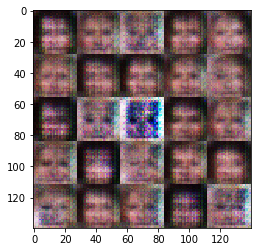

Epoch 1 Step 320... Discriminator Loss: 1.2951... Generator Loss: 1.4569
Epoch 1 Step 340... Discriminator Loss: 1.0616... Generator Loss: 1.1095
Epoch 1 Step 360... Discriminator Loss: 1.2434... Generator Loss: 2.7601
Epoch 1 Step 380... Discriminator Loss: 0.7865... Generator Loss: 2.5730
Epoch 1 Step 400... Discriminator Loss: 0.9050... Generator Loss: 2.4692


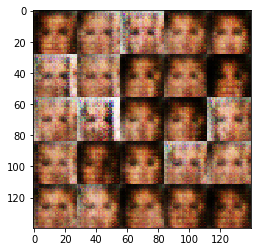

Epoch 1 Step 420... Discriminator Loss: 0.7760... Generator Loss: 3.4466
Epoch 1 Step 440... Discriminator Loss: 1.2527... Generator Loss: 0.8765
Epoch 1 Step 460... Discriminator Loss: 0.7480... Generator Loss: 1.6736
Epoch 1 Step 480... Discriminator Loss: 0.8188... Generator Loss: 1.2721
Epoch 1 Step 500... Discriminator Loss: 0.8154... Generator Loss: 1.1380


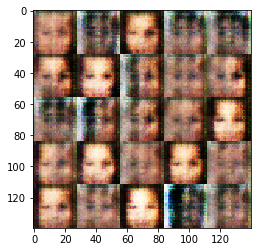

Epoch 1 Step 520... Discriminator Loss: 1.4771... Generator Loss: 1.7580
Epoch 1 Step 540... Discriminator Loss: 0.6917... Generator Loss: 1.7699
Epoch 1 Step 560... Discriminator Loss: 0.8410... Generator Loss: 1.8155
Epoch 1 Step 580... Discriminator Loss: 0.5768... Generator Loss: 1.9360
Epoch 1 Step 600... Discriminator Loss: 0.6490... Generator Loss: 3.3261


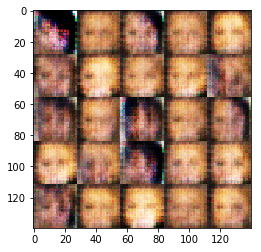

Epoch 1 Step 620... Discriminator Loss: 1.4430... Generator Loss: 0.8991
Epoch 1 Step 640... Discriminator Loss: 0.8999... Generator Loss: 2.4800
Epoch 1 Step 660... Discriminator Loss: 1.1459... Generator Loss: 1.6304
Epoch 1 Step 680... Discriminator Loss: 1.5067... Generator Loss: 0.9049
Epoch 1 Step 700... Discriminator Loss: 0.7236... Generator Loss: 1.6883


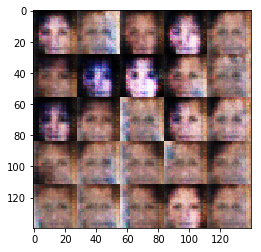

Epoch 1 Step 720... Discriminator Loss: 0.9470... Generator Loss: 1.3790
Epoch 1 Step 740... Discriminator Loss: 0.8564... Generator Loss: 1.9497
Epoch 1 Step 760... Discriminator Loss: 0.9619... Generator Loss: 1.5724
Epoch 1 Step 780... Discriminator Loss: 0.6785... Generator Loss: 1.8834
Epoch 1 Step 800... Discriminator Loss: 1.0680... Generator Loss: 3.3815


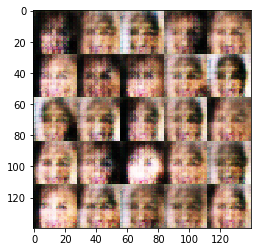

Epoch 1 Step 820... Discriminator Loss: 1.0866... Generator Loss: 0.8466
Epoch 1 Step 840... Discriminator Loss: 0.8118... Generator Loss: 3.1454
Epoch 1 Step 860... Discriminator Loss: 1.0426... Generator Loss: 1.0743
Epoch 1 Step 880... Discriminator Loss: 0.7942... Generator Loss: 2.2948
Epoch 1 Step 900... Discriminator Loss: 0.6468... Generator Loss: 2.0110


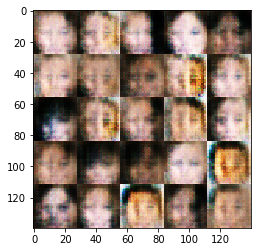

Epoch 1 Step 920... Discriminator Loss: 1.0835... Generator Loss: 0.9913
Epoch 1 Step 940... Discriminator Loss: 0.8256... Generator Loss: 1.6210
Epoch 1 Step 960... Discriminator Loss: 0.7650... Generator Loss: 2.6416
Epoch 1 Step 980... Discriminator Loss: 1.2332... Generator Loss: 0.8942
Epoch 1 Step 1000... Discriminator Loss: 0.9216... Generator Loss: 1.1870


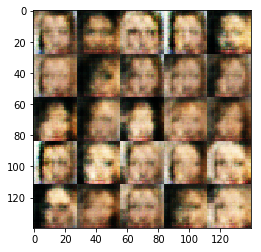

Epoch 1 Step 1020... Discriminator Loss: 0.9695... Generator Loss: 1.0545
Epoch 1 Step 1040... Discriminator Loss: 1.1191... Generator Loss: 5.7241
Epoch 1 Step 1060... Discriminator Loss: 0.8867... Generator Loss: 1.3305
Epoch 1 Step 1080... Discriminator Loss: 1.2964... Generator Loss: 0.7832
Epoch 1 Step 1100... Discriminator Loss: 1.4029... Generator Loss: 5.0219


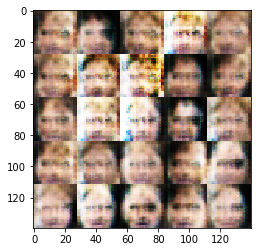

Epoch 1 Step 1120... Discriminator Loss: 0.8431... Generator Loss: 2.4407
Epoch 1 Step 1140... Discriminator Loss: 0.8727... Generator Loss: 2.6368
Epoch 1 Step 1160... Discriminator Loss: 1.1028... Generator Loss: 0.7829
Epoch 1 Step 1180... Discriminator Loss: 0.9519... Generator Loss: 1.2657
Epoch 1 Step 1200... Discriminator Loss: 0.9300... Generator Loss: 1.7003


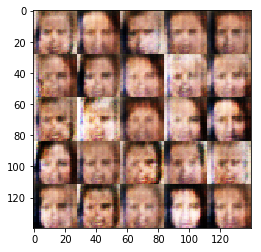

Epoch 1 Step 1220... Discriminator Loss: 0.6864... Generator Loss: 1.6598
Epoch 1 Step 1240... Discriminator Loss: 0.8691... Generator Loss: 1.7164
Epoch 1 Step 1260... Discriminator Loss: 0.5002... Generator Loss: 2.6709
Epoch 1 Step 1280... Discriminator Loss: 1.0171... Generator Loss: 1.2137
Epoch 1 Step 1300... Discriminator Loss: 0.6323... Generator Loss: 1.9538


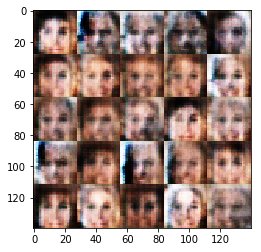

Epoch 1 Step 1320... Discriminator Loss: 0.7920... Generator Loss: 1.4191
Epoch 1 Step 1340... Discriminator Loss: 1.2451... Generator Loss: 0.8677
Epoch 1 Step 1360... Discriminator Loss: 0.6989... Generator Loss: 1.7891
Epoch 1 Step 1380... Discriminator Loss: 0.6010... Generator Loss: 2.0053
Epoch 1 Step 1400... Discriminator Loss: 0.5214... Generator Loss: 2.2668


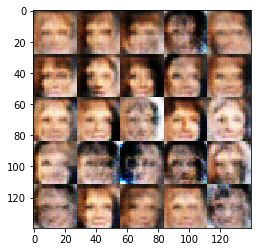

Epoch 1 Step 1420... Discriminator Loss: 0.6788... Generator Loss: 1.8621
Epoch 1 Step 1440... Discriminator Loss: 1.1681... Generator Loss: 1.0526
Epoch 1 Step 1460... Discriminator Loss: 0.7976... Generator Loss: 1.6586
Epoch 1 Step 1480... Discriminator Loss: 0.5143... Generator Loss: 2.4776
Epoch 1 Step 1500... Discriminator Loss: 1.1469... Generator Loss: 1.2474


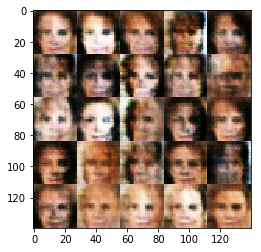

Epoch 1 Step 1520... Discriminator Loss: 0.7740... Generator Loss: 1.8291
Epoch 1 Step 1540... Discriminator Loss: 0.8578... Generator Loss: 1.6368
Epoch 1 Step 1560... Discriminator Loss: 0.8916... Generator Loss: 1.8052
Epoch 1 Step 1580... Discriminator Loss: 1.1018... Generator Loss: 1.8825
Epoch 1 Step 1600... Discriminator Loss: 0.7934... Generator Loss: 2.6998


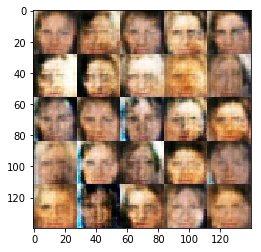

Epoch 1 Step 1620... Discriminator Loss: 0.8495... Generator Loss: 2.4329
Epoch 1 Step 1640... Discriminator Loss: 1.0977... Generator Loss: 1.0280
Epoch 1 Step 1660... Discriminator Loss: 0.8448... Generator Loss: 1.9061
Epoch 1 Step 1680... Discriminator Loss: 0.6590... Generator Loss: 1.6038
Epoch 1 Step 1700... Discriminator Loss: 1.0828... Generator Loss: 2.2620


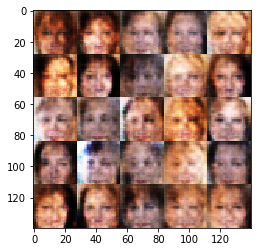

Epoch 1 Step 1720... Discriminator Loss: 1.1095... Generator Loss: 2.6630
Epoch 1 Step 1740... Discriminator Loss: 0.8811... Generator Loss: 1.2586
Epoch 1 Step 1760... Discriminator Loss: 0.9897... Generator Loss: 1.9324
Epoch 1 Step 1780... Discriminator Loss: 1.3744... Generator Loss: 1.0622
Epoch 1 Step 1800... Discriminator Loss: 0.7708... Generator Loss: 1.7651


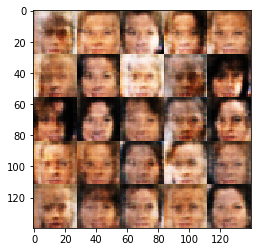

Epoch 1 Step 1820... Discriminator Loss: 0.9173... Generator Loss: 2.3441
Epoch 1 Step 1840... Discriminator Loss: 0.8100... Generator Loss: 1.9482
Epoch 1 Step 1860... Discriminator Loss: 1.2346... Generator Loss: 1.0574
Epoch 1 Step 1880... Discriminator Loss: 0.7239... Generator Loss: 3.3938
Epoch 1 Step 1900... Discriminator Loss: 1.0054... Generator Loss: 1.2007


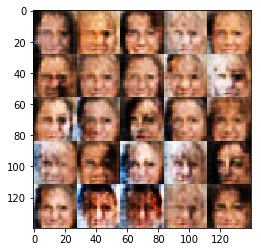

Epoch 1 Step 1920... Discriminator Loss: 1.0220... Generator Loss: 1.3179
Epoch 1 Step 1940... Discriminator Loss: 1.0977... Generator Loss: 1.2498
Epoch 1 Step 1960... Discriminator Loss: 0.8697... Generator Loss: 1.2770
Epoch 1 Step 1980... Discriminator Loss: 0.6207... Generator Loss: 2.3371
Epoch 1 Step 2000... Discriminator Loss: 0.8535... Generator Loss: 1.9575


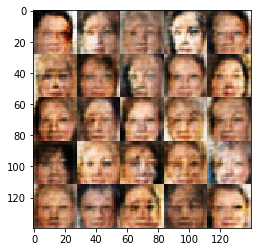

Epoch 1 Step 2020... Discriminator Loss: 1.3888... Generator Loss: 0.7688
Epoch 1 Step 2040... Discriminator Loss: 0.8570... Generator Loss: 2.1424
Epoch 1 Step 2060... Discriminator Loss: 0.7828... Generator Loss: 1.3771
Epoch 1 Step 2080... Discriminator Loss: 0.9587... Generator Loss: 1.7944
Epoch 1 Step 2100... Discriminator Loss: 0.9495... Generator Loss: 1.6789


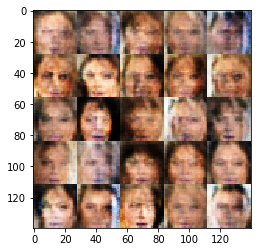

Epoch 1 Step 2120... Discriminator Loss: 0.7428... Generator Loss: 2.2704
Epoch 1 Step 2140... Discriminator Loss: 1.2734... Generator Loss: 0.9248
Epoch 1 Step 2160... Discriminator Loss: 0.7474... Generator Loss: 1.6774
Epoch 1 Step 2180... Discriminator Loss: 1.1350... Generator Loss: 2.4806
Epoch 1 Step 2200... Discriminator Loss: 0.7893... Generator Loss: 1.5213


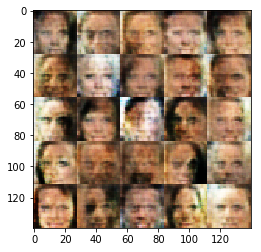

Epoch 1 Step 2220... Discriminator Loss: 1.2036... Generator Loss: 1.2095
Epoch 1 Step 2240... Discriminator Loss: 0.9505... Generator Loss: 1.6749
Epoch 1 Step 2260... Discriminator Loss: 0.8566... Generator Loss: 1.7559
Epoch 1 Step 2280... Discriminator Loss: 0.6268... Generator Loss: 1.8205
Epoch 1 Step 2300... Discriminator Loss: 0.8483... Generator Loss: 1.8847


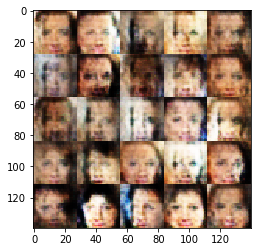

Epoch 1 Step 2320... Discriminator Loss: 0.9645... Generator Loss: 1.5996
Epoch 1 Step 2340... Discriminator Loss: 0.8443... Generator Loss: 1.7248
Epoch 1 Step 2360... Discriminator Loss: 0.8092... Generator Loss: 1.6414
Epoch 1 Step 2380... Discriminator Loss: 1.1043... Generator Loss: 2.1986
Epoch 1 Step 2400... Discriminator Loss: 0.8054... Generator Loss: 3.1188


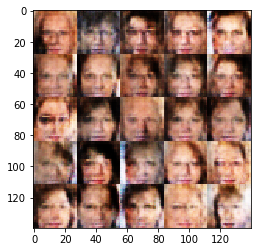

Epoch 1 Step 2420... Discriminator Loss: 1.2253... Generator Loss: 1.5137
Epoch 1 Step 2440... Discriminator Loss: 0.7759... Generator Loss: 1.7618
Epoch 1 Step 2460... Discriminator Loss: 0.7265... Generator Loss: 1.3037
Epoch 1 Step 2480... Discriminator Loss: 0.8643... Generator Loss: 1.4505
Epoch 1 Step 2500... Discriminator Loss: 0.7146... Generator Loss: 2.1555


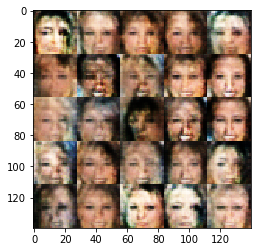

Epoch 1 Step 2520... Discriminator Loss: 0.8824... Generator Loss: 2.8529
Epoch 1 Step 2540... Discriminator Loss: 0.7158... Generator Loss: 2.0279
Epoch 1 Step 2560... Discriminator Loss: 0.6759... Generator Loss: 1.7060
Epoch 1 Step 2580... Discriminator Loss: 0.8244... Generator Loss: 0.9325
Epoch 1 Step 2600... Discriminator Loss: 0.9637... Generator Loss: 1.2475


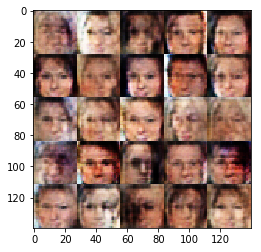

Epoch 1 Step 2620... Discriminator Loss: 1.0225... Generator Loss: 1.1975
Epoch 1 Step 2640... Discriminator Loss: 0.9220... Generator Loss: 1.2440
Epoch 1 Step 2660... Discriminator Loss: 0.8417... Generator Loss: 1.9761
Epoch 1 Step 2680... Discriminator Loss: 0.9460... Generator Loss: 1.6564
Epoch 1 Step 2700... Discriminator Loss: 1.0197... Generator Loss: 1.3650


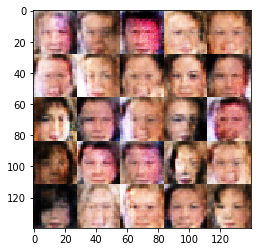

Epoch 1 Step 2720... Discriminator Loss: 0.8205... Generator Loss: 1.5693
Epoch 1 Step 2740... Discriminator Loss: 0.9579... Generator Loss: 1.7657
Epoch 1 Step 2760... Discriminator Loss: 1.4103... Generator Loss: 0.9510
Epoch 1 Step 2780... Discriminator Loss: 0.9239... Generator Loss: 1.3159
Epoch 1 Step 2800... Discriminator Loss: 0.8917... Generator Loss: 2.1309


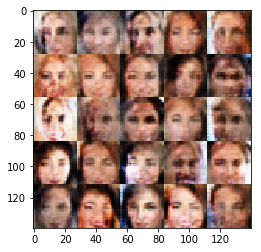

Epoch 1 Step 2820... Discriminator Loss: 1.5271... Generator Loss: 0.7628
Epoch 1 Step 2840... Discriminator Loss: 1.1500... Generator Loss: 0.9261
Epoch 1 Step 2860... Discriminator Loss: 0.9261... Generator Loss: 1.4157
Epoch 1 Step 2880... Discriminator Loss: 0.8626... Generator Loss: 1.8659
Epoch 1 Step 2900... Discriminator Loss: 0.8378... Generator Loss: 1.8847


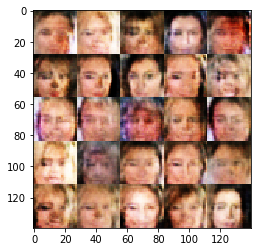

Epoch 1 Step 2920... Discriminator Loss: 0.8529... Generator Loss: 1.6092
Epoch 1 Step 2940... Discriminator Loss: 1.0954... Generator Loss: 1.3382
Epoch 1 Step 2960... Discriminator Loss: 0.9980... Generator Loss: 1.2866
Epoch 1 Step 2980... Discriminator Loss: 1.0514... Generator Loss: 1.4653
Epoch 1 Step 3000... Discriminator Loss: 0.9121... Generator Loss: 1.1602


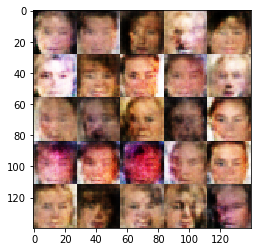

Epoch 1 Step 3020... Discriminator Loss: 0.7162... Generator Loss: 1.9758
Epoch 1 Step 3040... Discriminator Loss: 0.6301... Generator Loss: 3.1328
Epoch 1 Step 3060... Discriminator Loss: 1.1045... Generator Loss: 2.3380
Epoch 1 Step 3080... Discriminator Loss: 0.9400... Generator Loss: 1.7594
Epoch 1 Step 3100... Discriminator Loss: 0.9090... Generator Loss: 1.1512


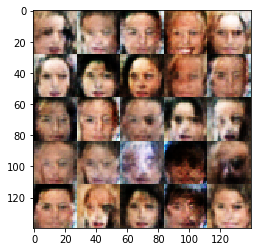

Epoch 1 Step 3120... Discriminator Loss: 0.7228... Generator Loss: 1.5025
Epoch 1 Step 3140... Discriminator Loss: 0.8453... Generator Loss: 2.3828
Epoch 1 Step 3160... Discriminator Loss: 0.9374... Generator Loss: 1.6857
Epoch 1 Step 3180... Discriminator Loss: 1.0006... Generator Loss: 1.9488
Epoch 1 Step 3200... Discriminator Loss: 1.3452... Generator Loss: 0.8086


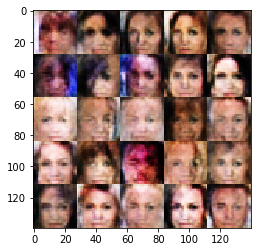

Epoch 1 Step 3220... Discriminator Loss: 0.8482... Generator Loss: 2.2944
Epoch 1 Step 3240... Discriminator Loss: 0.8960... Generator Loss: 1.3651
Epoch 1 Step 3260... Discriminator Loss: 0.9401... Generator Loss: 1.2072
Epoch 1 Step 3280... Discriminator Loss: 0.9314... Generator Loss: 1.5397
Epoch 1 Step 3300... Discriminator Loss: 1.1032... Generator Loss: 1.1183


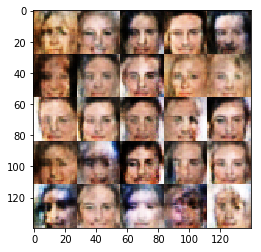

Epoch 1 Step 3320... Discriminator Loss: 0.9945... Generator Loss: 0.7988
Epoch 1 Step 3340... Discriminator Loss: 0.9042... Generator Loss: 1.7334
Epoch 1 Step 3360... Discriminator Loss: 0.6052... Generator Loss: 2.6830
Epoch 1 Step 3380... Discriminator Loss: 1.1105... Generator Loss: 0.8389
Epoch 1 Step 3400... Discriminator Loss: 1.0106... Generator Loss: 1.4292


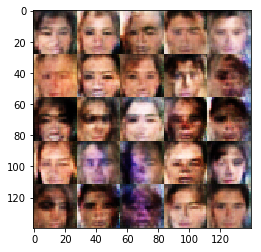

Epoch 1 Step 3420... Discriminator Loss: 0.8727... Generator Loss: 1.9431
Epoch 1 Step 3440... Discriminator Loss: 0.8581... Generator Loss: 1.4163
Epoch 1 Step 3460... Discriminator Loss: 0.8055... Generator Loss: 2.0727
Epoch 1 Step 3480... Discriminator Loss: 0.8933... Generator Loss: 1.0315
Epoch 1 Step 3500... Discriminator Loss: 0.9875... Generator Loss: 1.6807


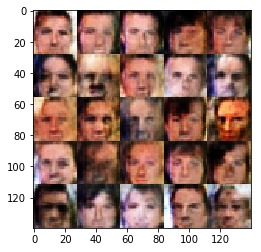

Epoch 1 Step 3520... Discriminator Loss: 1.1531... Generator Loss: 1.0966
Epoch 1 Step 3540... Discriminator Loss: 0.9351... Generator Loss: 1.3705
Epoch 1 Step 3560... Discriminator Loss: 0.9644... Generator Loss: 2.3582
Epoch 1 Step 3580... Discriminator Loss: 1.1086... Generator Loss: 1.2009
Epoch 1 Step 3600... Discriminator Loss: 0.8622... Generator Loss: 1.5559


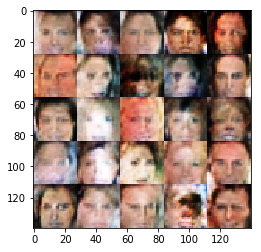

Epoch 1 Step 3620... Discriminator Loss: 0.9402... Generator Loss: 1.2678
Epoch 1 Step 3640... Discriminator Loss: 1.2536... Generator Loss: 0.9928
Epoch 1 Step 3660... Discriminator Loss: 0.9420... Generator Loss: 1.1778
Epoch 1 Step 3680... Discriminator Loss: 0.9679... Generator Loss: 1.8353
Epoch 1 Step 3700... Discriminator Loss: 0.7743... Generator Loss: 1.4548


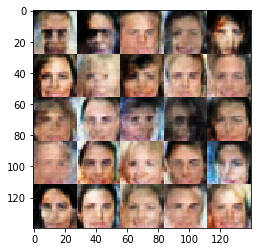

Epoch 1 Step 3720... Discriminator Loss: 0.7209... Generator Loss: 2.1866
Epoch 1 Step 3740... Discriminator Loss: 1.1374... Generator Loss: 0.9643
Epoch 1 Step 3760... Discriminator Loss: 1.0472... Generator Loss: 1.0371
Epoch 1 Step 3780... Discriminator Loss: 0.7679... Generator Loss: 1.6694
Epoch 1 Step 3800... Discriminator Loss: 0.9786... Generator Loss: 1.5778


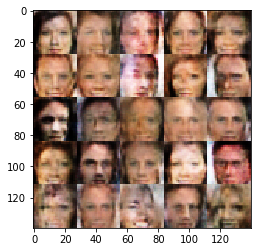

Epoch 1 Step 3820... Discriminator Loss: 1.0570... Generator Loss: 1.3149
Epoch 1 Step 3840... Discriminator Loss: 1.0621... Generator Loss: 0.9792
Epoch 1 Step 3860... Discriminator Loss: 0.8341... Generator Loss: 1.5418
Epoch 1 Step 3880... Discriminator Loss: 1.2470... Generator Loss: 1.2085
Epoch 1 Step 3900... Discriminator Loss: 0.8093... Generator Loss: 2.9744


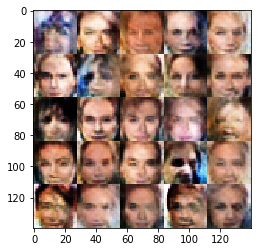

Epoch 1 Step 3920... Discriminator Loss: 0.9549... Generator Loss: 1.2430
Epoch 1 Step 3940... Discriminator Loss: 1.0150... Generator Loss: 1.0124
Epoch 1 Step 3960... Discriminator Loss: 1.0825... Generator Loss: 1.2628
Epoch 1 Step 3980... Discriminator Loss: 0.9675... Generator Loss: 1.9951
Epoch 1 Step 4000... Discriminator Loss: 0.9911... Generator Loss: 1.0237


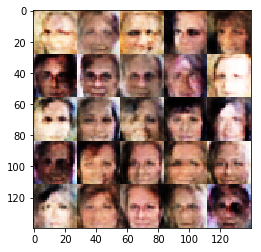

Epoch 1 Step 4020... Discriminator Loss: 0.8551... Generator Loss: 2.5225
Epoch 1 Step 4040... Discriminator Loss: 0.9019... Generator Loss: 1.5670
Epoch 1 Step 4060... Discriminator Loss: 1.1013... Generator Loss: 1.4254
Epoch 1 Step 4080... Discriminator Loss: 0.7684... Generator Loss: 1.6894
Epoch 1 Step 4100... Discriminator Loss: 1.2185... Generator Loss: 1.7884


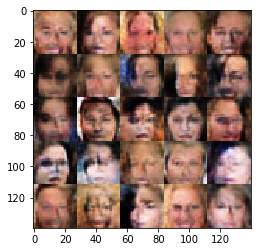

Epoch 1 Step 4120... Discriminator Loss: 1.1252... Generator Loss: 2.3305
Epoch 1 Step 4140... Discriminator Loss: 0.9931... Generator Loss: 1.1458
Epoch 1 Step 4160... Discriminator Loss: 0.9961... Generator Loss: 1.0413
Epoch 1 Step 4180... Discriminator Loss: 1.0049... Generator Loss: 1.5000
Epoch 1 Step 4200... Discriminator Loss: 0.6642... Generator Loss: 1.9141


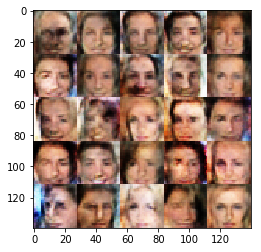

Epoch 1 Step 4220... Discriminator Loss: 1.0992... Generator Loss: 1.3135
Epoch 1 Step 4240... Discriminator Loss: 0.8797... Generator Loss: 1.9531
Epoch 1 Step 4260... Discriminator Loss: 1.0308... Generator Loss: 1.2079
Epoch 1 Step 4280... Discriminator Loss: 0.7631... Generator Loss: 1.3999
Epoch 1 Step 4300... Discriminator Loss: 0.9009... Generator Loss: 1.2419


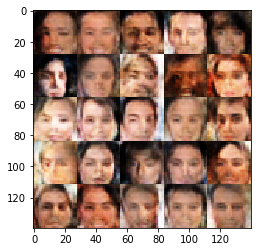

Epoch 1 Step 4320... Discriminator Loss: 1.0594... Generator Loss: 1.2731
Epoch 1 Step 4340... Discriminator Loss: 0.9437... Generator Loss: 1.0656
Epoch 1 Step 4360... Discriminator Loss: 1.0485... Generator Loss: 1.2095
Epoch 1 Step 4380... Discriminator Loss: 0.9560... Generator Loss: 1.3228
Epoch 1 Step 4400... Discriminator Loss: 0.8378... Generator Loss: 1.5497


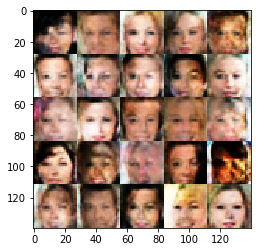

Epoch 1 Step 4420... Discriminator Loss: 1.1004... Generator Loss: 2.1736
Epoch 1 Step 4440... Discriminator Loss: 1.2637... Generator Loss: 1.5775
Epoch 1 Step 4460... Discriminator Loss: 0.9213... Generator Loss: 1.8221
Epoch 1 Step 4480... Discriminator Loss: 1.0905... Generator Loss: 1.9045
Epoch 1 Step 4500... Discriminator Loss: 1.1794... Generator Loss: 1.4531


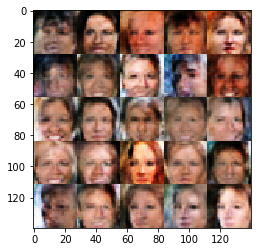

Epoch 1 Step 4520... Discriminator Loss: 1.0979... Generator Loss: 0.9445
Epoch 1 Step 4540... Discriminator Loss: 1.2326... Generator Loss: 2.1130
Epoch 1 Step 4560... Discriminator Loss: 1.1630... Generator Loss: 1.2295
Epoch 1 Step 4580... Discriminator Loss: 1.1508... Generator Loss: 0.9777
Epoch 1 Step 4600... Discriminator Loss: 0.7313... Generator Loss: 1.9728


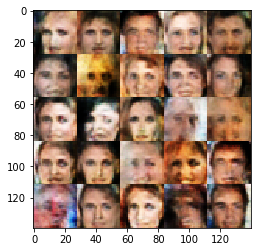

Epoch 1 Step 4620... Discriminator Loss: 1.0775... Generator Loss: 1.0420
Epoch 1 Step 4640... Discriminator Loss: 0.9223... Generator Loss: 1.6455
Epoch 1 Step 4660... Discriminator Loss: 0.9811... Generator Loss: 1.4454
Epoch 1 Step 4680... Discriminator Loss: 0.8448... Generator Loss: 2.0043
Epoch 1 Step 4700... Discriminator Loss: 0.6572... Generator Loss: 1.8227


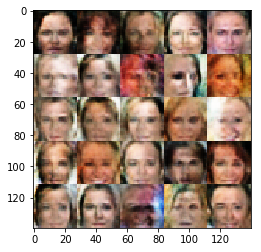

Epoch 1 Step 4720... Discriminator Loss: 0.9950... Generator Loss: 1.3935
Epoch 1 Step 4740... Discriminator Loss: 0.9185... Generator Loss: 1.5050
Epoch 1 Step 4760... Discriminator Loss: 1.0826... Generator Loss: 2.4754
Epoch 1 Step 4780... Discriminator Loss: 1.1064... Generator Loss: 1.5598
Epoch 1 Step 4800... Discriminator Loss: 0.7815... Generator Loss: 1.5773


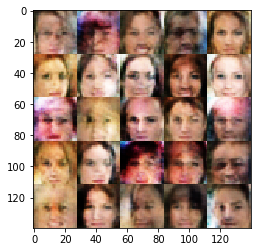

Epoch 1 Step 4820... Discriminator Loss: 0.9501... Generator Loss: 1.5281
Epoch 1 Step 4840... Discriminator Loss: 1.1450... Generator Loss: 1.4495
Epoch 1 Step 4860... Discriminator Loss: 0.9435... Generator Loss: 1.1590
Epoch 1 Step 4880... Discriminator Loss: 1.4465... Generator Loss: 1.7460
Epoch 1 Step 4900... Discriminator Loss: 0.9734... Generator Loss: 1.2911


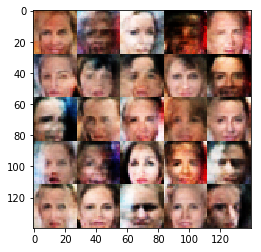

Epoch 1 Step 4920... Discriminator Loss: 1.1620... Generator Loss: 1.0699
Epoch 1 Step 4940... Discriminator Loss: 0.8981... Generator Loss: 1.3713
Epoch 1 Step 4960... Discriminator Loss: 1.2848... Generator Loss: 2.0169
Epoch 1 Step 4980... Discriminator Loss: 0.8696... Generator Loss: 1.4089
Epoch 1 Step 5000... Discriminator Loss: 0.9308... Generator Loss: 1.5190


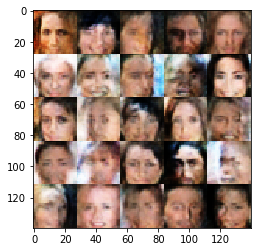

Epoch 1 Step 5020... Discriminator Loss: 0.9449... Generator Loss: 1.0440
Epoch 1 Step 5040... Discriminator Loss: 1.0342... Generator Loss: 1.2148
Epoch 1 Step 5060... Discriminator Loss: 0.8872... Generator Loss: 1.3374
Epoch 1 Step 5080... Discriminator Loss: 1.1405... Generator Loss: 1.4085
Epoch 1 Step 5100... Discriminator Loss: 1.2086... Generator Loss: 1.2910


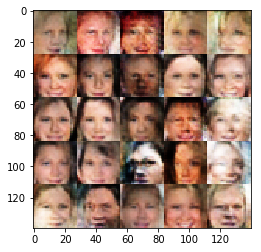

Epoch 1 Step 5120... Discriminator Loss: 1.4350... Generator Loss: 0.8302
Epoch 1 Step 5140... Discriminator Loss: 1.2529... Generator Loss: 0.8701
Epoch 1 Step 5160... Discriminator Loss: 1.1102... Generator Loss: 1.4003
Epoch 1 Step 5180... Discriminator Loss: 1.0080... Generator Loss: 1.5181
Epoch 1 Step 5200... Discriminator Loss: 1.0811... Generator Loss: 2.1685


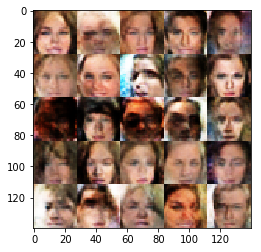

Epoch 1 Step 5220... Discriminator Loss: 0.9655... Generator Loss: 1.5614
Epoch 1 Step 5240... Discriminator Loss: 1.3089... Generator Loss: 1.4804
Epoch 1 Step 5260... Discriminator Loss: 1.1727... Generator Loss: 1.2721
Epoch 1 Step 5280... Discriminator Loss: 0.8533... Generator Loss: 1.5506
Epoch 1 Step 5300... Discriminator Loss: 0.8828... Generator Loss: 1.6195


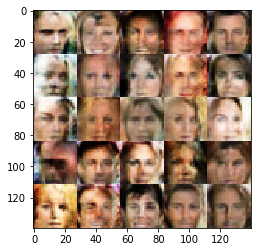

Epoch 1 Step 5320... Discriminator Loss: 0.8066... Generator Loss: 2.2863
Epoch 1 Step 5340... Discriminator Loss: 1.0427... Generator Loss: 0.9745
Epoch 1 Step 5360... Discriminator Loss: 1.0579... Generator Loss: 1.0164
Epoch 1 Step 5380... Discriminator Loss: 1.2459... Generator Loss: 1.2083
Epoch 1 Step 5400... Discriminator Loss: 0.8203... Generator Loss: 1.7955


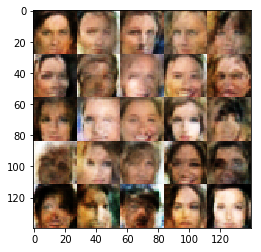

Epoch 1 Step 5420... Discriminator Loss: 0.5774... Generator Loss: 2.3477
Epoch 1 Step 5440... Discriminator Loss: 1.1061... Generator Loss: 1.7038
Epoch 1 Step 5460... Discriminator Loss: 1.0875... Generator Loss: 2.0335
Epoch 1 Step 5480... Discriminator Loss: 1.3071... Generator Loss: 0.7650
Epoch 1 Step 5500... Discriminator Loss: 1.2612... Generator Loss: 1.4240


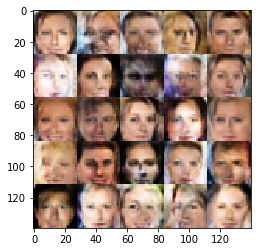

Epoch 1 Step 5520... Discriminator Loss: 1.0596... Generator Loss: 1.8079
Epoch 1 Step 5540... Discriminator Loss: 1.0523... Generator Loss: 1.3564
Epoch 1 Step 5560... Discriminator Loss: 1.1081... Generator Loss: 1.7251
Epoch 1 Step 5580... Discriminator Loss: 0.7391... Generator Loss: 1.5401
Epoch 1 Step 5600... Discriminator Loss: 0.9566... Generator Loss: 1.6587


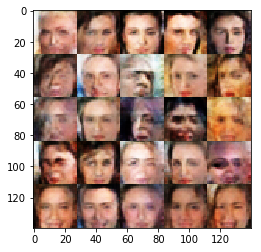

Epoch 1 Step 5620... Discriminator Loss: 1.1528... Generator Loss: 1.0307
Epoch 1 Step 5640... Discriminator Loss: 0.6451... Generator Loss: 1.7858
Epoch 1 Step 5660... Discriminator Loss: 1.0079... Generator Loss: 1.4506
Epoch 1 Step 5680... Discriminator Loss: 0.9384... Generator Loss: 1.9607
Epoch 1 Step 5700... Discriminator Loss: 0.7975... Generator Loss: 1.5229


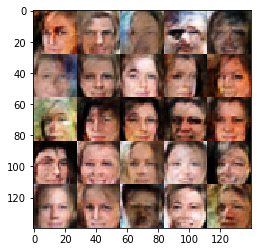

Epoch 1 Step 5720... Discriminator Loss: 0.9124... Generator Loss: 1.6916
Epoch 1 Step 5740... Discriminator Loss: 0.9848... Generator Loss: 1.1396
Epoch 1 Step 5760... Discriminator Loss: 1.4766... Generator Loss: 1.0349
Epoch 1 Step 5780... Discriminator Loss: 1.0030... Generator Loss: 1.2461
Epoch 1 Step 5800... Discriminator Loss: 1.4238... Generator Loss: 0.9597


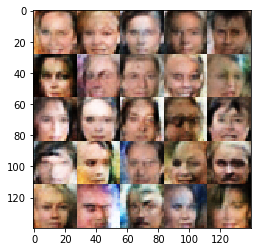

Epoch 1 Step 5820... Discriminator Loss: 1.0286... Generator Loss: 1.0299
Epoch 1 Step 5840... Discriminator Loss: 1.0141... Generator Loss: 1.3342
Epoch 1 Step 5860... Discriminator Loss: 0.8895... Generator Loss: 1.3259
Epoch 1 Step 5880... Discriminator Loss: 1.0721... Generator Loss: 1.6411
Epoch 1 Step 5900... Discriminator Loss: 0.9856... Generator Loss: 2.2040


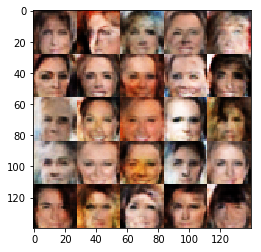

Epoch 1 Step 5920... Discriminator Loss: 0.8138... Generator Loss: 1.7329
Epoch 1 Step 5940... Discriminator Loss: 0.8517... Generator Loss: 1.6583
Epoch 1 Step 5960... Discriminator Loss: 1.0517... Generator Loss: 1.2235
Epoch 1 Step 5980... Discriminator Loss: 1.3341... Generator Loss: 0.8676
Epoch 1 Step 6000... Discriminator Loss: 1.1057... Generator Loss: 1.1063


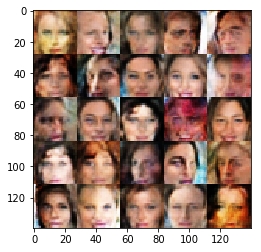

Epoch 1 Step 6020... Discriminator Loss: 0.9914... Generator Loss: 1.2367
Epoch 1 Step 6040... Discriminator Loss: 1.0517... Generator Loss: 1.2055
Epoch 1 Step 6060... Discriminator Loss: 1.0482... Generator Loss: 1.0154
Epoch 1 Step 6080... Discriminator Loss: 1.0625... Generator Loss: 0.8251
Epoch 1 Step 6100... Discriminator Loss: 0.7950... Generator Loss: 1.2798


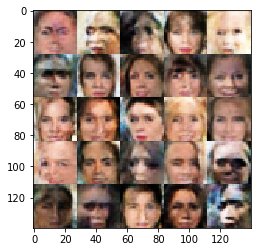

Epoch 1 Step 6120... Discriminator Loss: 1.0086... Generator Loss: 1.5033
Epoch 1 Step 6140... Discriminator Loss: 1.1978... Generator Loss: 0.7313
Epoch 1 Step 6160... Discriminator Loss: 1.0741... Generator Loss: 0.9205
Epoch 1 Step 6180... Discriminator Loss: 1.1433... Generator Loss: 1.2062
Epoch 1 Step 6200... Discriminator Loss: 1.0136... Generator Loss: 1.6127


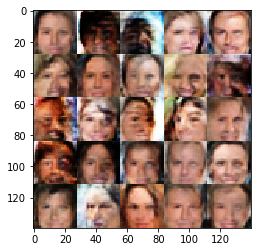

Epoch 1 Step 6220... Discriminator Loss: 1.0681... Generator Loss: 1.3516
Epoch 1 Step 6240... Discriminator Loss: 1.2311... Generator Loss: 2.1155
Epoch 1 Step 6260... Discriminator Loss: 1.0063... Generator Loss: 1.1864
Epoch 1 Step 6280... Discriminator Loss: 1.1694... Generator Loss: 1.5499
Epoch 1 Step 6300... Discriminator Loss: 1.4015... Generator Loss: 0.9317


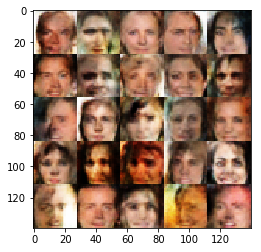

Epoch 1 Step 6320... Discriminator Loss: 1.0799... Generator Loss: 1.5846


IndexError: list index out of range

In [78]:
#batch_size = 32
#z_dim = 100
#learning_rate = 0.0002
#beta1 = 0.5
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))

with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.